<a href="https://colab.research.google.com/github/BerkAIcelik/hate-speech-detection-system-using-TR-tweets/blob/main/Untitled8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install zemberek-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 MB 11.5 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141214 sha256=a3200516a36427b633bcb5deb171788bdee86c1169269bd40e0cddb5b01015a3
  Stored in directory: /root/.cache/pip/wheels/a7/20/bd/e1477d664f22d99989fd28ee1a43d6633dddb5cb9e801350d5
Successfully built antlr4-python3-runtime


In [ ]:
from google.colab import drive
import nltk
import pandas as pd
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from zemberek import TurkishMorphology
from zemberek.normalization import TurkishSpellChecker
from zemberek.tokenization import TurkishTokenizer

In [ ]:
# Google Drive'ı bağlama
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# NLTK stopwords veri setini indirme
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Zemberek bileşenlerini yükleme
morphology = TurkishMorphology.create_with_defaults()
spell_checker = TurkishSpellChecker(morphology)
tokenizer = TurkishTokenizer.DEFAULT
stop_words = set(stopwords.words('turkish'))


INFO:zemberek.morphology.turkish_morphology:TurkishMorphology instance initialized in 6.012364864349365


2025-01-02 00:14:53,095 - zemberek.morphology.turkish_morphology - INFO
Msg: TurkishMorphology instance initialized in 6.012364864349365



In [ ]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 6.9 MB/s eta 0:00:00


In [ ]:
# İlk veri seti: Türkçe Nefret Söylemi Veriseti.xlsx
datafile1 = '/content/drive/MyDrive/Türkçe Nefret Söylemi Veriseti.xlsx'
sheets1 = pd.ExcelFile(datafile1)
# Tüm sayfa adlarını incele
sheet_names1 = sheets1.sheet_names
# TOPLAM sheet'ini hariç tutup diğerlerini birleştirme
combined_data1 = pd.DataFrame()
for sheet_name in sheet_names1:
    if sheet_name != 'TOPLAM':
        temp_df = sheets1.parse(sheet_name, header=1)  # 2. satırdan itibaren sütun isimleri alınıyor
        combined_data1 = pd.concat([combined_data1, temp_df], ignore_index=True)

In [ ]:
# İlk 3
print("Birleştirilmiş veri setinin ilk 3 satırı:")
print(combined_data1.head(3))

Birleştirilmiş veri setinin ilk 3 satırı:
   row ID                                              Tweet     Etiket  \
0  Row589  ya orospu cocuklari hepiniz niye ayni anda yaz...     nefret   
1  Row593  Ciddiye alan tüm dünyanın beynini sileyim.. \n...  saldırgan   
2  Row600  Kayıtlı İstihdama geçiş programına göre (?)\nŞ...    hiçbiri   

  Alt Etiket   Etiket.1 Alt Etiket.1   Etiket.2 Alt Etiket.2 Etiket.3  \
0      etnik     nefret        etnik     nefret        etnik      NaN   
1        NaN  saldırgan          NaN  saldırgan          NaN      NaN   
2        NaN    hiçbiri          NaN    hiçbiri          NaN      NaN   

  Alt Etiket.3  ...  User - Location User - Time Zone User - Statuses  \
0          NaN  ...          gökyüzü              NaN            9417   
1          NaN  ...             İMKB              NaN            8747   
2          NaN  ...            T. C.              NaN           27697   

   User - Followers  User - Friends  User - Favourites  Unnamed: 35  Ro

In [ ]:
# İkinci veri seti: Türkçe Nefret Söylemi Veri Seti v1.xlsx
datafile2 = '/content/drive/MyDrive/Türkçe Nefret Söylemi Veri Seti v1.xlsx'
sheets2 = pd.ExcelFile(datafile2)
# 1000 Tweet sheet'ini yükle
combined_data2 = sheets2.parse('1000 Tweet')  # 2. satırdan itibaren sütun isimleri alınıyor

In [ ]:
# Sütunların uyumluluğunu kontrol etme
columns1 = combined_data1.columns
columns2 = combined_data2.columns
# Eşleşen ve eşleşmeyen sütunları belirleme
matching_columns = [col for col in columns1 if col in columns2]
non_matching_columns1 = [col for col in columns1 if col not in columns2]
non_matching_columns2 = [col for col in columns2 if col not in columns1]

In [ ]:
print("Eşleşen sütunlar:", matching_columns)
print("Birinci veri setinde olup ikinci veri setinde olmayan sütunlar:", non_matching_columns1)
print("İkinci veri setinde olup birinci veri setinde olmayan sütunlar:", non_matching_columns2)

Eşleşen sütunlar: ['row ID', 'Tweet', 'Etiket', 'Alt Etiket', 'Tweet ID', 'Time', 'Favorited', 'Retweeted', 'Is Favourited', 'Is Retweeted', 'Is Retweet', 'Retweet from', 'Latitude', 'Longitude', 'Country', 'User', 'User - Profile image', 'User - Name', 'User - ID', 'User - Description', 'User - URL', 'User - Creation time', 'User - Language', 'User - Location', 'User - Time Zone', 'User - Statuses', 'User - Followers', 'User - Friends', 'User - Favourites']
Birinci veri setinde olup ikinci veri setinde olmayan sütunlar: ['Etiket.1', 'Alt Etiket.1', 'Etiket.2', 'Alt Etiket.2', 'Etiket.3', 'Alt Etiket.3', 'Unnamed: 35', 'RowID', 'Unnamed: 22', 'Row ID']
İkinci veri setinde olup birinci veri setinde olmayan sütunlar: []


In [ ]:
# Sadece eşleşen sütunları birleştirme
combined_data1 = combined_data1[matching_columns]
combined_data2 = combined_data2[matching_columns]
final_combined_data = pd.concat([combined_data1, combined_data2], ignore_index=True)


In [ ]:
# İlk 3
print("Birleştirilmiş nihai veri setinin ilk 3 satırı:")
print(final_combined_data.head(3))

Birleştirilmiş nihai veri setinin ilk 3 satırı:
   row ID                                              Tweet     Etiket  \
0  Row589  ya orospu cocuklari hepiniz niye ayni anda yaz...     nefret   
1  Row593  Ciddiye alan tüm dünyanın beynini sileyim.. \n...  saldırgan   
2  Row600  Kayıtlı İstihdama geçiş programına göre (?)\nŞ...    hiçbiri   

  Alt Etiket      Tweet ID                 Time Favorited  Retweeted  \
0      etnik  1.169530e+23  2019-09-05 11:33:56        12          1   
1        NaN  1.169530e+23  2019-09-05 11:32:09         3          0   
2        NaN  1.169530e+23  2019-09-05 11:29:34        26          1   

   Is Favourited  Is Retweeted  ...  \
0              0             0  ...   
1              0             0  ...   
2              0             0  ...   

                                  User - Description  User - URL  \
0                                 duygusal bir topum         NaN   
1  mühendis.. finansla da ilgilenir.. asla yatırı...         NaN   
2

In [ ]:
# Birleştirilmiş nihai veri setini kaydetme
final_combined_data.to_csv('birlesik_veri_seti.csv', index=False)
print("Birleştirilmiş veri seti 'birlesik_veri_seti.csv' olarak kaydedildi.")

# Veri setinin genel yapısını inceleme
print("Veri setinin genel bilgisi:")
print(final_combined_data.info())


Birleştirilmiş veri seti 'birlesik_veri_seti.csv' olarak kaydedildi.
Veri setinin genel bilgisi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11224 entries, 0 to 11223
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   row ID                10959 non-null  object 
 1   Tweet                 11224 non-null  object 
 2   Etiket                11224 non-null  object 
 3   Alt Etiket            2612 non-null   object 
 4   Tweet ID              11223 non-null  float64
 5   Time                  11224 non-null  object 
 6   Favorited             11224 non-null  object 
 7   Retweeted             11224 non-null  int64  
 8   Is Favourited         11224 non-null  int64  
 9   Is Retweeted          11224 non-null  int64  
 10  Is Retweet            11224 non-null  int64  
 11  Retweet from          1 non-null      float64
 12  Latitude              13 non-null     float64
 13  Longitude             13

In [ ]:
# Birleştirilmiş nihai veri setini sadece Row ID, Tweet ve Etiket sütunları ile hazırlama
filtered_data = final_combined_data[['row ID', 'Tweet', 'Etiket']].copy()

# Row ID değerlerini yeniden isimlendirme
filtered_data['row ID'] = ['row ' + str(i) for i in range(len(filtered_data))]

# İlk ve son satırı gösterme
print("Filtrelenmiş veri setinin ilk satırı:")
print(filtered_data.head(1))

print("Filtrelenmiş veri setinin son satırı:")
print(filtered_data.tail(1))

Filtrelenmiş veri setinin ilk satırı:
  row ID                                              Tweet  Etiket
0  row 0  ya orospu cocuklari hepiniz niye ayni anda yaz...  nefret
Filtrelenmiş veri setinin son satırı:
          row ID                                              Tweet   Etiket
11223  row 11223  ulan maçı unutayım kafam dağılsın diye netflix...  hiçbiri


Sınıf dağılımı:
Etiket
hiçbiri      8386
nefret       2612
saldırgan     226
Name: count, dtype: int64


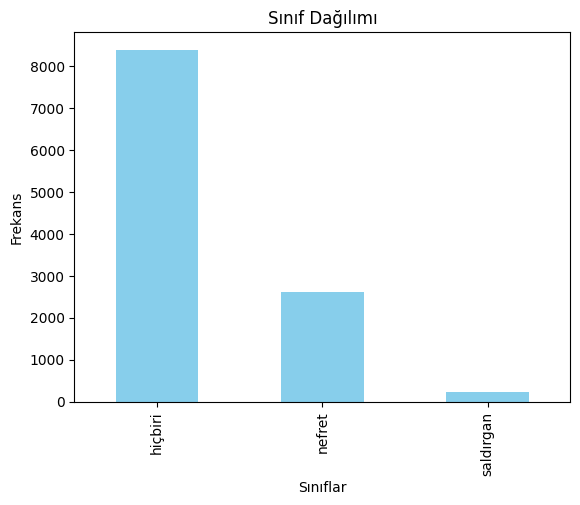

In [ ]:
# Sınıf dağılımı analizi
print("Sınıf dağılımı:")
class_distribution = filtered_data['Etiket'].value_counts()
print(class_distribution)

# Sınıf dağılımını görselleştirme
import matplotlib.pyplot as plt

class_distribution.plot(kind='bar', color='skyblue')
plt.title('Sınıf Dağılımı')
plt.xlabel('Sınıflar')
plt.ylabel('Frekans')
plt.show()

In [ ]:
from zemberek import TurkishMorphology
from functools import lru_cache
import time
import re
from zemberek import TurkishMorphology, TurkishSentenceNormalizer


normalizer = TurkishSentenceNormalizer(morphology)
# Zemberek Morphology başlatılıyor
morphology = TurkishMorphology.create_with_defaults()

# Kontrol sayacı
check_counter = 0

@lru_cache(maxsize=50000)
def cached_spell_check(word):
    global check_counter
    check_counter += 1
    if check_counter % 1000 == 0:
        print(f"{check_counter} kelime kontrol edildi...")

    # Yazım kontrolü ve öneri alma
    suggestions = spell_checker.suggest_for_word(word)
    corrected_word = suggestions[0] if suggestions else word

    # Lemmatization işlemi
    analysis = morphology.analyze(corrected_word)
    lemmas = [result.get_stem() for result in analysis]

    # Eğer lemma bulunmuşsa ilkini döndür, yoksa düzeltilmiş kelimeyi döndür
    return lemmas[0] if lemmas else corrected_word

# Tokenizasyon ve stopword temizleme
def tokenize_and_clean(text):
    # Küçük harfe çevirme
    text = text.lower()

    # URL'leri kaldırma
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Kullanıcı etiketlerini kaldırma (@mention)
    text = re.sub(r'@\w+', '', text)

    # Sayıları kaldırma
    text = re.sub(r'[0-9]', '', text)

    # Noktalama işaretlerini kaldırma
    text = re.sub(r'[^\w\s]', '', text)

    # Fazla boşlukları temizleme
    text = re.sub(r'\s+', ' ', text).strip()

    # Normalizasyon (Loodos mantığına göre Zemberek ile)
    text = normalizer.normalize(text)  # Metni normalize et (örneğin, yanlış yazımları düzelt)

    # Tokenize işlemi (kelimelere ayırma)
    tokens = [token.content for token in tokenizer.tokenize(text)]

    # Stopwords (gereksiz kelimeleri) kaldırma
    tokens = [word for word in tokens if word not in stop_words]

    return tokens


# Yazım düzeltmesi yapılmış token'ları saklamak için fonksiyon
def correct_tokens_separately(tokens):
    corrected_tokens = [cached_spell_check(token) for token in tokens]
    return corrected_tokens  # Burada, her kelimeyi düzeltip geri döndürüyoruz.



# Metin ön işleme adımlarını ayrı ayrı çalıştırma ve süre ölçme
processed_data = filtered_data.copy()

# Tokenizasyon ve stopword temizleme süresi
start_time = time.time()
processed_data['Tokens'] = processed_data['Tweet'].apply(tokenize_and_clean)
end_time = time.time()
print(f"Tokenizasyon ve stopword temizleme süresi: {end_time - start_time:.2f} saniye")

#yazım düzeltme süresi
start_time = time.time()
processed_data['Processed Tokens'] = processed_data['Tokens'].apply(correct_tokens_separately)
end_time = time.time()
print(f"yazım düzeltme süresi: {end_time - start_time:.2f} saniye")

# İşlenmiş veri setini kontrol etme
print("İşlenmiş veri setinin ilk 5 satırı:")
print(processed_data.head())
print("\nİşlenmiş veri setinin son 5 satırı:")
print(processed_data.tail())



INFO:zemberek.morphology.turkish_morphology:TurkishMorphology instance initialized in 5.976700782775879


2025-01-02 00:15:20,787 - zemberek.morphology.turkish_morphology - INFO
Msg: TurkishMorphology instance initialized in 5.976700782775879

Tokenizasyon ve stopword temizleme süresi: 899.59 saniye
1000 kelime kontrol edildi...
2000 kelime kontrol edildi...
3000 kelime kontrol edildi...
4000 kelime kontrol edildi...
5000 kelime kontrol edildi...
6000 kelime kontrol edildi...
7000 kelime kontrol edildi...
8000 kelime kontrol edildi...
9000 kelime kontrol edildi...
10000 kelime kontrol edildi...
11000 kelime kontrol edildi...
12000 kelime kontrol edildi...
13000 kelime kontrol edildi...
14000 kelime kontrol edildi...
15000 kelime kontrol edildi...
16000 kelime kontrol edildi...
17000 kelime kontrol edildi...
18000 kelime kontrol edildi...
19000 kelime kontrol edildi...
20000 kelime kontrol edildi...
21000 kelime kontrol edildi...
22000 kelime kontrol edildi...
23000 kelime kontrol edildi...
24000 kelime kontrol edildi...
25000 kelime kontrol edildi...
26000 kelime kontrol edildi...
27000 ke

In [ ]:
# İşlenmiş veriyi CSV olarak kaydetme
output_file = 'processed_data1.csv'
processed_data.to_csv(output_file, index=False)
print(f"İşlenmiş veri seti '{output_file}' olarak kaydedildi.")


İşlenmiş veri seti 'processed_data1.csv' olarak kaydedildi.


In [ ]:
# Google Drive'ı bağlama
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive

import pandas as pd
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt


In [ ]:
import pandas as pd

# CSV dosyasını okuma
input_file = '/content/drive/MyDrive/processed_data1.csv'
processed_data = pd.read_csv(input_file)

print("CSV dosyası başarıyla yüklendi!")
print("İlk 5 satır:")
print(processed_data.head())


In [ ]:

import logging
import sys
import multiprocessing

from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

In [ ]:
import itertools

In [ ]:
# processed_data['Tokens'] üzerinde split işlemi yapılmaz, çünkü veri zaten tokenize edilmiş.
print(processed_data.head())

processed_data['Processed Tokens'] = processed_data['Processed Tokens'].apply(lambda x: eval(x) if isinstance(x, str) else x)
print(processed_data['Processed Tokens'].apply(lambda x: 'eşcinsel' in x))
a

# Model eğitimi
word2_model1 = Word2Vec(sentences=processed_data['Processed Tokens'], vector_size=100, window=5, min_count=1, sg=1, negative=4, epochs=10, workers=multiprocessing.cpu_count())

# 'eşcinsel' kelimesiyle en benzer kelimeleri bulalım
print(word2_model1.wv.most_similar(positive=['eşcinsel']))


  row ID                                              Tweet     Etiket  \
0  row 0  ya orospu cocuklari hepiniz niye ayni anda yaz...     nefret   
1  row 1  Ciddiye alan tüm dünyanın beynini sileyim.. \n...  saldırgan   
2  row 2  Kayıtlı İstihdama geçiş programına göre (?)\nŞ...    hiçbiri   
3  row 3  Hastaneye git Suriyeli. PTT ye git Suriyeli. P...     nefret   
4  row 4               Cölesi bitmiş suriyeli gibiyim bugün    hiçbiri   

                                              Tokens  \
0  ['orospu', 'çocukları', 'hepiniz', 'aynı', 'an...   
1  ['ciddiye', 'alan', 'dünyanın', 'beynini', 'si...   
2  ['kayıtlı', 'istihdama', 'geçiş', 'programına'...   
3  ['hastaneye', 'git', 'suriyeli', 'ptt', 'ye', ...   
4  ['colesi', 'bitmiş', 'suriyeli', 'gibiyim', 'b...   

                                    Processed Tokens  
0  ['orospu', 'çocuk', 'hep', 'aynı', 'an', 'yap'...  
1  ['ciddi', 'ol', 'dünya', 'beyn', 'bil', 'iki',...  
2  ['kayıt', 'istihdam', 'geniş', 'program', 'gör... 

In [ ]:
import numpy as np

def get_sentence_vector(model, tokens):
    # Tokenler modelde varsa, kelime vektörlerini alıp ortalamasını döndürüyoruz
    word_vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


In [ ]:
# Cümle vektörlerini elde ediyoruz
processed_data['Sentence Vector'] = processed_data['Processed Tokens'].apply(lambda x: get_sentence_vector(word2_model1, x))
from sklearn.preprocessing import LabelEncoder

# Etiket sütununu sayısal verilere dönüştürme
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(processed_data['Etiket'])

# Bu aşamada, eğer etiketli bir veri kümeniz varsa, etiketleri de alıyoruz
X = np.array(processed_data['Sentence Vector'].tolist())  # Giriş vektörleri
y = numeric_labels  # Etiketler (sınıflar)


In [ ]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 9.4 MB/s eta 0:00:00


In [ ]:
pip install tensorflow --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 122.8 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [ ]:
# Processed Tokens sütununu doğru formata dönüştürme
processed_data['Processed Tokens'] = processed_data['Processed Tokens'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Formatı kontrol etme
print(processed_data['Processed Tokens'].head())


0    [orospu, çocuk, hep, aynı, an, yap, tüm, ciddi...
1    [ciddi, ol, dünya, beyn, bil, iki, gün, baş, g...
2    [kayıt, istihdam, geniş, program, göre, şimdil...
3    [hastane, ait, suriye, ptt, de, ait, suriye, p...
4                     [coke, git, suriye, gibi, bugün]
Name: Processed Tokens, dtype: object


In [ ]:
# Gerekli kütüphaneleri yükleme
import multiprocessing
import numpy as np
from gensim.models import Word2Vec, KeyedVectors


# Word2Vec modelini yükleme
model_path = "/content/drive/MyDrive/trmodel"  # Model dosyasının yolu
turkish_word2vec = KeyedVectors.load_word2vec_format(model_path, binary=True)
print("Model başarıyla yüklendi.")

# 'Processed Tokens' sütununu listeye çevirin
tokenized_texts = processed_data['Processed Tokens'].tolist()
print(f"Toplam {len(tokenized_texts)} metin yüklendi.")

# Yeni bir Word2Vec modeli oluştur
model = Word2Vec(vector_size=turkish_word2vec.vector_size, window=5, min_count=1, workers=multiprocessing.cpu_count() - 1)
model.build_vocab(tokenized_texts)

# Pre-trained modelin ağırlıklarını yeni modele aktar
word_dict = {word: turkish_word2vec.get_vector(word) for word in model.wv.index_to_key if word in turkish_word2vec.key_to_index}

# Pre-trained vektörleri yeni modele kopyala
for word, vector in word_dict.items():
    if word in model.wv.key_to_index:
        model.wv.vectors[model.wv.key_to_index[word]] = vector

print(f"Transfer edilen kelime sayısı: {len(word_dict)}")

# Yeni verilerle modeli fine-tune etme
model.train(
    tokenized_texts,
    total_examples=len(tokenized_texts),
    epochs=10
)

# Fine-tuned modelinizi kaydedin
fine_tuned_model_path = "fine_tuned_word2vec.model"
model.save(fine_tuned_model_path)
print(f"Fine-tuned model '{fine_tuned_model_path}' dosyasına kaydedildi.")



Model başarıyla yüklendi.
Toplam 11224 metin yüklendi.
Transfer edilen kelime sayısı: 10513
Fine-tuned model 'fine_tuned_word2vec.model' dosyasına kaydedildi.


In [ ]:

# Fine-tuned modeli yükleyin
model = Word2Vec.load(fine_tuned_model_path)
print("Fine-tuned model başarıyla yüklendi.")

# Belge vektörlerini hesaplayan fonksiyon
def get_document_vector(tokens, word2vec_model, vector_size=100):
    word_vectors = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    if len(word_vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)

# Cümle vektörlerini hesaplama
processed_data['Sentence Vector'] = processed_data['Processed Tokens'].apply(lambda x: get_document_vector(x, model, vector_size=model.vector_size))
print("Cümle vektörleri başarıyla hesaplandı.")

Fine-tuned model başarıyla yüklendi.
Cümle vektörleri başarıyla hesaplandı.


In [ ]:

# Etiket sütununu sayısal verilere dönüştürme
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(processed_data['Etiket'])

# Bu aşamada, eğer etiketli bir veri kümeniz varsa, etiketleri de alıyoruz
X = np.array(processed_data['Sentence Vector'].tolist())  # Giriş vektörleri
y = numeric_labels  # Etiketler (sınıflar)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Daha önce oluşturulan kombinasyonlar (count_combination_data, tfidf_combination_data) kullanılacak
# Çıktılar için dosya yolunu ayarlama
output_dir = "/content/drive/MyDrive/outputs1"
os.makedirs(output_dir, exist_ok=True)

# Etiketleri Yükleme ve Sayısal Dönüşüm
labels = processed_data['Etiket']
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)
print(f"Etiketler dönüştürüldü: {list(label_encoder.classes_)}")

# Veri Seti Bölme Fonksiyonu

def split_data(matrix, labels):
    # LightGBM ve diğer modeller için gerekli dönüşüm
    matrix = matrix.astype(np.float32) if hasattr(matrix, 'astype') else matrix
    return train_test_split(matrix, labels, test_size=0.2, random_state=42)

# Performans Ölçüm Fonksiyonu
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Precision, Recall, F1-Score ve Accuracy hesaplamaları
    precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
    recall = recall_score(y_test, predictions, average='weighted', zero_division=0)
    f1 = f1_score(y_test, predictions, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_test, predictions)

    # Metriği ekrana yazdırma
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
    return precision, recall, f1, accuracy, predictions

# Confusion Matrix Görselleştirme Fonksiyonu
def save_confusion_matrix(y_true, y_pred, model_name, data_type):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f"Confusion Matrix - {model_name} ({data_type})")
    file_path = os.path.join(output_dir, f"confusion_matrix_{model_name}_{data_type}.png")
    plt.savefig(file_path, bbox_inches='tight')
    plt.close()
    print(f"Confusion matrix kaydedildi: {file_path}")

# Eğitim ve Doğrulama Metriklerini Kaydetme Fonksiyonu
def save_training_validation_metrics(history, model_name, data_type):
    epochs = range(1, len(history['loss']) + 1)

    # Loss Grafiği
    plt.plot(epochs, history['loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title(f"Loss - {model_name} ({data_type})")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    file_path_loss = os.path.join(output_dir, f"loss_{model_name}_{data_type}.png")
    plt.savefig(file_path_loss, bbox_inches='tight')
    plt.close()
    print(f"Loss grafiği kaydedildi: {file_path_loss}")

    # Accuracy Grafiği
    plt.plot(epochs, history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"Accuracy - {model_name} ({data_type})")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    file_path_acc = os.path.join(output_dir, f"accuracy_{model_name}_{data_type}.png")
    plt.savefig(file_path_acc, bbox_inches='tight')
    plt.close()
    print(f"Accuracy grafiği kaydedildi: {file_path_acc}")

# Kombinasyonlar için Performans Değerlendirme Tablosu
results = []






Etiketler dönüştürüldü: ['hiçbiri', 'nefret', 'saldırgan']


In [ ]:
def evaluate_random_forest_with_word2vec():
    print(f"Word2Vec ile Random Forest modeli değerlendiriliyor...")

    # Cümle vektörlerini alıyoruz
    X = np.array(processed_data['Sentence Vector'].tolist())
    y = numeric_labels  # Etiketler

    X_train, X_test, y_train, y_test = split_data(X, y)

    model = RandomForestClassifier(
        n_estimators=400,
        max_depth=10,
        min_samples_split=8,
        random_state=42
    )
    precision, recall, f1, accuracy, predictions = evaluate_model(model, X_train, X_test, y_train, y_test)
    results.append({
        'Model': 'Random Forest',
        'Data Type': 'Word2Vec',
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Accuracy': accuracy
    })

    # Confusion Matrix Kaydetme
    save_confusion_matrix(y_test, predictions, "RandomForest", 'Word2Vec')

In [ ]:
# Değerlendirme İşlemi
print("Random Forest Modeli Değerlendiriliyor...")
evaluate_random_forest_with_word2vec()

Random Forest Modeli Değerlendiriliyor...
Word2Vec ile Random Forest modeli değerlendiriliyor...
Precision: 0.7783, Recall: 0.7653, F1-Score: 0.6855, Accuracy: 0.7653
Confusion matrix kaydedildi: /content/drive/MyDrive/outputs1/confusion_matrix_RandomForest_Word2Vec.png


In [ ]:
# XGBoost Modeli
def evaluate_xgboost():
  print(f"Word2Vec ile Xgboost modeli değerlendiriliyor...")
 # Cümle vektörlerini alıyoruz
  X = np.array(processed_data['Sentence Vector'].tolist())
  y = numeric_labels  # Etiketler

  X_train, X_test, y_train, y_test = split_data(X, y)
  model = XGBClassifier(
        eval_metric='logloss',
        random_state=42,
        n_estimators=800,
        max_depth=15,
        learning_rate=0.25,
        subsample=0.7
            )
  precision, recall, f1, accuracy, predictions = evaluate_model(model, X_train, X_test, y_train, y_test)
  results.append({
        'Model': 'XGBoost',
        'Data Type': 'Word2Vec',
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Accuracy': accuracy
            })

            # Confusion Matrix Kaydetme
  save_confusion_matrix(y_test, predictions, "XGBoost", 'Word2Vec')


In [ ]:
# Değerlendirme İşlemi
print("xgboost Modeli Değerlendiriliyor...")
evaluate_xgboost()


xgboost Modeli Değerlendiriliyor...
Word2Vec ile Xgboost modeli değerlendiriliyor...
Precision: 0.8025, Recall: 0.8040, F1-Score: 0.7702, Accuracy: 0.8040
Confusion matrix kaydedildi: /content/drive/MyDrive/outputs1/confusion_matrix_XGBoost_Word2Vec.png


In [ ]:
# LightGBM Modeli
def evaluate_lightgbm():
  print(f"Word2Vec ile lightgbm modeli değerlendiriliyor...")
 # Cümle vektörlerini alıyoruz
  X = np.array(processed_data['Sentence Vector'].tolist())
  y = numeric_labels  # Etiketler
  X_train, X_test, y_train, y_test = split_data(X, y)
  model = LGBMClassifier(random_state=42, num_leaves=20, max_depth=20, learning_rate=0.005, n_estimators=800)
  precision, recall, f1, accuracy, predictions = evaluate_model(model, X_train, X_test, y_train, y_test)
  results.append({
                'Model': 'LightGBM',
                'Data Type': 'Word2Vec',
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'Accuracy': accuracy
            })

            # Confusion Matrix Kaydetme


  save_confusion_matrix(y_test, predictions, "LightGBM", 'Word2Vec')



In [ ]:
print("lightgbm Modeli Değerlendiriliyor...")
evaluate_lightgbm()

lightgbm Modeli Değerlendiriliyor...
Word2Vec ile lightgbm modeli değerlendiriliyor...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102000
[LightGBM] [Info] Number of data points in the train set: 8979, number of used features: 400
[LightGBM] [Info] Start training from score -0.289652
[LightGBM] [Info] Start training from score -1.465892
[LightGBM] [Info] Start training from score -3.882288


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Precision: 0.7746, Recall: 0.7924, F1-Score: 0.7494, Accuracy: 0.7924
Confusion matrix kaydedildi: /content/drive/MyDrive/outputs1/confusion_matrix_LightGBM_Word2Vec.png


In [ ]:

from keras.optimizers import Adam  # Adam optimizer import ediliyor
# ANN Modeli
def evaluate_ann():
  print(f"Word2Vec ile Xgboost modeli değerlendiriliyor...")
 # Cümle vektörlerini alıyoruz
  X = np.array(processed_data['Sentence Vector'].tolist())
  y = numeric_labels  # Etiketler
  X_train, X_test, y_train, y_test = split_data(X, y)

  # Kategorik etiketlere dönüştürme
  y_train_cat = to_categorical(y_train, num_classes=len(label_encoder.classes_))
  y_test_cat = to_categorical(y_test, num_classes=len(label_encoder.classes_))

  # Modeli tanımlama
  input_dim = X_train.shape[1]
  model = Sequential([
      Dense(128, activation='relu', input_dim=input_dim),
      Dropout(0.3),
      Dense(64, activation='relu'),
      Dropout(0.3),
      Dense(len(label_encoder.classes_), activation='softmax')
  ])
  optimizer = Adam(learning_rate=0.0001)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  # Modeli eğitme
  early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
  history = model.fit(
      X_train,
      y_train_cat,
      validation_data=(X_test, y_test_cat),
      epochs=50,
      batch_size=4,
      callbacks=[early_stopping],
      verbose=1
  )

  # Tahminler ve performans
  predictions = model.predict(X_test).argmax(axis=1)

  # Precision, Recall, F1-Score ve Accuracy hesaplamaları
  precision = precision_score(y_test, predictions, average='weighted')
  recall = recall_score(y_test, predictions, average='weighted')
  f1 = f1_score(y_test, predictions, average='weighted')
  accuracy = accuracy_score(y_test, predictions)  # Accuracy hesaplama

  results.append({
      'Model': 'ANN',
      'Data Type': 'Word2Vec',
      'Precision': precision,
      'Recall': recall,
      'F1-Score': f1,
      'Accuracy': accuracy  # Accuracy'yi ekle
  })

  # Confusion Matrix Kaydetme
  save_confusion_matrix(y_test, predictions, "ANN", 'Word2Vec')

  # Eğitim ve doğrulama metriklerini kaydetme
  history_dict = {
      'loss': history.history['loss'],
      'val_loss': history.history['val_loss'],
      'accuracy': history.history['accuracy'],
      'val_accuracy': history.history['val_accuracy']
  }
  save_training_validation_metrics(history_dict, "ANN", 'Word2Vec')


In [ ]:
print("ANN Modeli Değerlendiriliyor...")
evaluate_ann()

ANN Modeli Değerlendiriliyor...
Word2Vec ile Xgboost modeli değerlendiriliyor...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2245/2245 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7417 - loss: 0.6582 - val_accuracy: 0.7795 - val_loss: 0.5350
Epoch 2/50
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7738 - loss: 0.5406 - val_accuracy: 0.7893 - val_loss: 0.5127
Epoch 3/50
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7893 - loss: 0.5087 - val_accuracy: 0.7906 - val_loss: 0.5045
Epoch 4/50
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8064 - loss: 0.4770 - val_accuracy: 0.7889 - val_loss: 0.4974
Epoch 5/50
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8089 - loss: 0.4678 - val_accuracy: 0.7982 - val_loss: 0.4972
Epoch 6/50
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8209 - loss: 0.4498 - val_accuracy: 0.7991 - val_loss: 0.4911
Epoch 7/50
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8281 - loss: 0.4299 - val_accuracy: 0.8009 - val_loss: 0.4931
Epoch 8/50
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8251 - loss: 0.4297 - val_accurac

In [ ]:
# Sonuçları DataFrame olarak kaydetme
results_df = pd.DataFrame(results)
print("Sonuçlar:")
print(results_df)

# Sonuçları CSV olarak kaydetme
results_df.to_csv('model_performance_results.csv', index=False)
print("Sonuçlar 'model_performance_results.csv' dosyasına kaydedildi.")

Sonuçlar:
           Model Data Type  Precision    Recall  F1-Score  Accuracy
0  Random Forest  Word2Vec   0.778316  0.765256  0.685489  0.765256
1        XGBoost  Word2Vec   0.802501  0.804009  0.770188  0.804009
2       LightGBM  Word2Vec   0.774639  0.792428  0.749425  0.792428
3            ANN  Word2Vec   0.797101  0.804009  0.788682  0.804009
Sonuçlar 'model_performance_results.csv' dosyasına kaydedildi.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warn

Seçilen kombinasyonlar için resampling işlemleri tamamlandı ve veri setleri modelde kullanılabilir hale getirildi.
Rastgele seçilen örnek: combined_Word2Vec


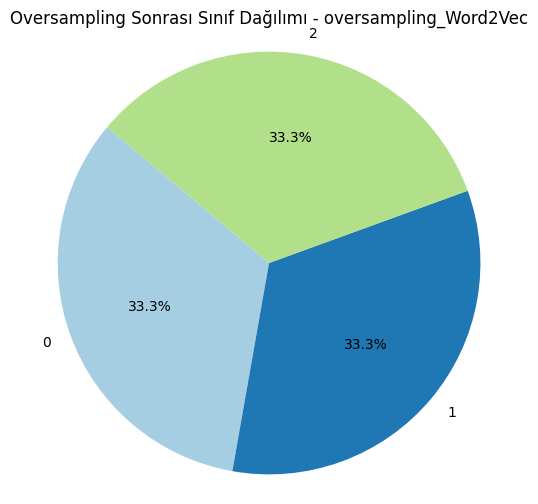

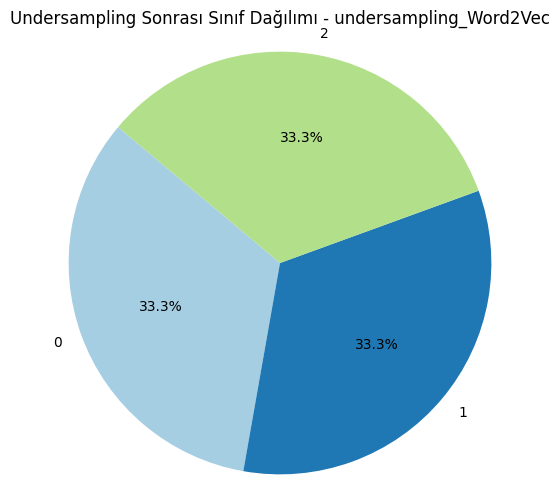

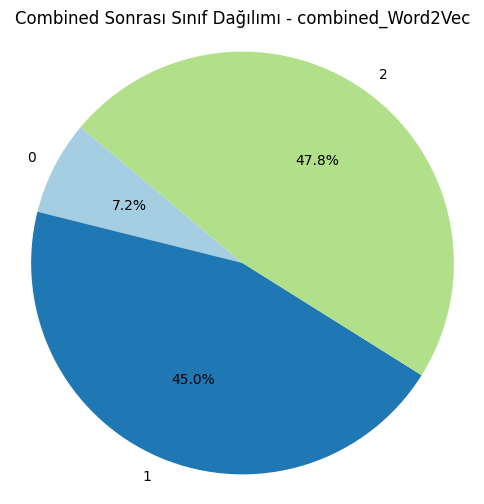

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# Resampling işlemleri için kullanılacak fonksiyonlar
def resample_data(X, y, method):
    """
    Resampling işlemini gerçekleştirir (oversampling, undersampling veya combined).
    """
    if method == 'oversampling':
        resampler = SMOTE(random_state=42)
    elif method == 'undersampling':
        resampler = RandomUnderSampler(random_state=42)
    elif method == 'combined':
        resampler = SMOTEENN(random_state=42)
    else:
        raise ValueError("Geçersiz resampling yöntemi: 'oversampling', 'undersampling', veya 'combined' olmalı.")

    X_resampled, y_resampled = resampler.fit_resample(X, y)
    return X_resampled, y_resampled


# Tüm veri setleri için resampling işlemleri
resampled_data_sets = {}

# Orijinal veri
X_original = np.array(processed_data['Sentence Vector'].tolist())  # Giriş vektörleri
y_original = numeric_labels  # Etiketler (sınıflar)
# Oversampling sonrası
X_oversampled, y_oversampled = resample_data(X_original, y_original, method='oversampling')
resampled_data_sets[f"oversampling_{'Word2Vec'}"] = (X_oversampled, y_oversampled)

# Undersampling sonrası
X_undersampled, y_undersampled = resample_data(X_original, y_original, method='undersampling')
resampled_data_sets[f"undersampling_{'Word2Vec'}"] = (X_undersampled, y_undersampled)

# Combined yöntem sonrası
X_combined, y_combined = resample_data(X_original, y_original, method='combined')
resampled_data_sets[f"combined_{'Word2Vec'}"] = (X_combined, y_combined)

print("Seçilen kombinasyonlar için resampling işlemleri tamamlandı ve veri setleri modelde kullanılabilir hale getirildi.")

# Rastgele 1 örnek seçme ve inceleme
random_sample_key = np.random.choice(list(resampled_data_sets.keys()))
print(f"Rastgele seçilen örnek: {random_sample_key}")
X_sample, y_sample = resampled_data_sets[random_sample_key]

# Pasta grafikleri çizme fonksiyonu
def plot_pie_chart(y, title):
    labels, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
    plt.title(title)
    plt.axis('equal')
    plt.show()

# Resampling yöntemlerine göre pasta grafikleri çizdirme
methods = ['oversampling', 'undersampling', 'combined']
for method in methods:
    sample_key = f"{method}_{random_sample_key.split('_', 1)[1]}"
    if sample_key in resampled_data_sets:
        _, y_resampled = resampled_data_sets[sample_key]
        plot_pie_chart(y_resampled, f"{method.capitalize()} Sonrası Sınıf Dağılımı - {sample_key}")


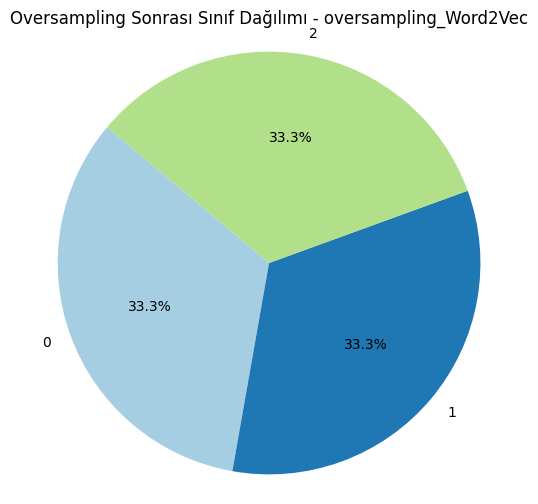

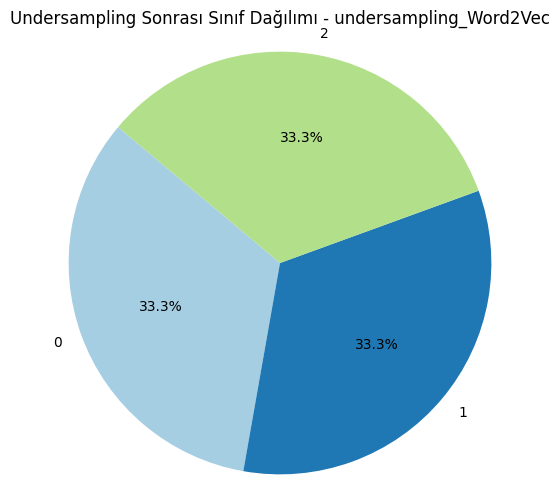

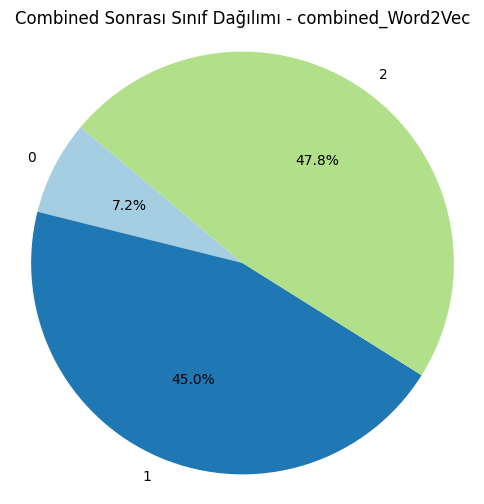

In [ ]:
# Pasta grafikleri çizme fonksiyonu
def plot_pie_chart(y, title):
    labels, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
    plt.title(title)
    plt.axis('equal')
    plt.show()

# Resampling yöntemlerine göre pasta grafikleri çizdirme
methods = ['oversampling', 'undersampling', 'combined']
for method in methods:
    sample_key = f"{method}_{random_sample_key.split('_', 1)[1]}"
    if sample_key in resampled_data_sets:
        _, y_resampled = resampled_data_sets[sample_key]
        plot_pie_chart(y_resampled, f"{method.capitalize()} Sonrası Sınıf Dağılımı - {sample_key}")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Daha önce oluşturulan kombinasyonlar (count_combination_data, tfidf_combination_data) kullanılacak
# Çıktılar için dosya yolunu ayarlama
output_dir = "/content/drive/MyDrive/outputs1_resample"
os.makedirs(output_dir, exist_ok=True)

# Etiketleri Yükleme ve Sayısal Dönüşüm
labels = processed_data['Etiket']
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)
print(f"Etiketler dönüştürüldü: {list(label_encoder.classes_)}")

# Veri Seti Bölme Fonksiyonu

def split_data(matrix, labels):
    # LightGBM ve diğer modeller için gerekli dönüşüm
    matrix = matrix.astype(np.float32) if hasattr(matrix, 'astype') else matrix
    return train_test_split(matrix, labels, test_size=0.2, random_state=42)

# Performans Ölçüm Fonksiyonu
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Precision, Recall, F1-Score ve Accuracy hesaplamaları
    precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
    recall = recall_score(y_test, predictions, average='weighted', zero_division=0)
    f1 = f1_score(y_test, predictions, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_test, predictions)

    # Metriği ekrana yazdırma
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
    return precision, recall, f1, accuracy, predictions

# Confusion Matrix Görselleştirme Fonksiyonu
def save_confusion_matrix(y_true, y_pred, model_name, data_type, combination):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f"Confusion Matrix - {model_name} ({data_type} - {combination})")
    file_path = os.path.join(output_dir, f"confusion_matrix_{model_name}_{data_type}_{combination}.png")
    plt.savefig(file_path, bbox_inches='tight')
    plt.close()
    print(f"Confusion matrix kaydedildi: {file_path}")

# Eğitim ve Doğrulama Metriklerini Kaydetme Fonksiyonu
def save_training_validation_metrics(history, model_name, data_type, combination):
    epochs = range(1, len(history['loss']) + 1)

    # Loss Grafiği
    plt.plot(epochs, history['loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title(f"Loss - {model_name} ({data_type} - {combination})")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    file_path_loss = os.path.join(output_dir, f"loss_{model_name}_{data_type}_{combination}.png")
    plt.savefig(file_path_loss, bbox_inches='tight')
    plt.close()
    print(f"Loss grafiği kaydedildi: {file_path_loss}")

    # Accuracy Grafiği
    plt.plot(epochs, history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"Accuracy - {model_name} ({data_type} - {combination})")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    file_path_acc = os.path.join(output_dir, f"accuracy_{model_name}_{data_type}_{combination}.png")
    plt.savefig(file_path_acc, bbox_inches='tight')
    plt.close()
    print(f"Accuracy grafiği kaydedildi: {file_path_acc}")

# Kombinasyonlar için Performans Değerlendirme Tablosu
results = []

Etiketler dönüştürüldü: ['hiçbiri', 'nefret', 'saldırgan']


In [ ]:

# Random Forest Modeli

def evaluate_random_forest_resampled():
    for key, (X_resampled, y_resampled) in resampled_data_sets.items():
        print(f"Random Forest ile {key} kombinasyonu değerlendiriliyor...")
        X_train, X_test, y_train, y_test = split_data(X_resampled, y_resampled)
        model = RandomForestClassifier(
            random_state=42,
            n_estimators=400,
            max_depth=10,
            min_samples_split=8

        )
        precision, recall, f1, accuracy, predictions = evaluate_model(model, X_train, X_test, y_train, y_test)
        results.append({
            'Model': 'Random Forest',
            'Data Type': 'Resampled',
            'Kombinasyon': key,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Accuracy': accuracy
        })

        # Confusion Matrix Kaydetme
        save_confusion_matrix(y_test, predictions, "RandomForest", "Resampled", key)



In [ ]:
print("random forest Modeli Değerlendiriliyor...")
evaluate_random_forest_resampled()

random forest Modeli Değerlendiriliyor...
Random Forest ile oversampling_Word2Vec kombinasyonu değerlendiriliyor...
Precision: 0.8812, Recall: 0.8822, F1-Score: 0.8809, Accuracy: 0.8822
Confusion matrix kaydedildi: /content/drive/MyDrive/outputs1_resample/confusion_matrix_RandomForest_Resampled_oversampling_Word2Vec.png
Random Forest ile undersampling_Word2Vec kombinasyonu değerlendiriliyor...
Precision: 0.5618, Recall: 0.5441, F1-Score: 0.5431, Accuracy: 0.5441
Confusion matrix kaydedildi: /content/drive/MyDrive/outputs1_resample/confusion_matrix_RandomForest_Resampled_undersampling_Word2Vec.png
Random Forest ile combined_Word2Vec kombinasyonu değerlendiriliyor...
Precision: 0.9481, Recall: 0.9444, F1-Score: 0.9331, Accuracy: 0.9444
Confusion matrix kaydedildi: /content/drive/MyDrive/outputs1_resample/confusion_matrix_RandomForest_Resampled_combined_Word2Vec.png


In [ ]:

# XGBoost Modeli

def evaluate_xgboost_resampled():
    for key, (X_resampled, y_resampled) in resampled_data_sets.items():
        print(f"XGBoost ile {key} kombinasyonu değerlendiriliyor...")
        X_train, X_test, y_train, y_test = split_data(X_resampled, y_resampled)
        model = XGBClassifier(
            eval_metric='logloss',
            random_state=42,
            n_estimators=800,
            max_depth=15,
            learning_rate=0.25,
            subsample=0.7
        )
        precision, recall, f1, accuracy, predictions = evaluate_model(model, X_train, X_test, y_train, y_test)
        results.append({
            'Model': 'XGBoost',
            'Data Type': 'Resampled',
            'Kombinasyon': key,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Accuracy': accuracy
        })

        # Confusion Matrix Kaydetme
        save_confusion_matrix(y_test, predictions, "XGBoost", "Resampled", key)



In [ ]:
print("xgboost Modeli Değerlendiriliyor...")
evaluate_xgboost_resampled()

xgboost Modeli Değerlendiriliyor...
XGBoost ile oversampling_Word2Vec kombinasyonu değerlendiriliyor...
Precision: 0.9438, Recall: 0.9440, F1-Score: 0.9439, Accuracy: 0.9440
Confusion matrix kaydedildi: /content/drive/MyDrive/outputs1_resample/confusion_matrix_XGBoost_Resampled_oversampling_Word2Vec.png
XGBoost ile undersampling_Word2Vec kombinasyonu değerlendiriliyor...
Precision: 0.5529, Recall: 0.5368, F1-Score: 0.5405, Accuracy: 0.5368
Confusion matrix kaydedildi: /content/drive/MyDrive/outputs1_resample/confusion_matrix_XGBoost_Resampled_undersampling_Word2Vec.png
XGBoost ile combined_Word2Vec kombinasyonu değerlendiriliyor...
Precision: 0.9854, Recall: 0.9855, F1-Score: 0.9850, Accuracy: 0.9855
Confusion matrix kaydedildi: /content/drive/MyDrive/outputs1_resample/confusion_matrix_XGBoost_Resampled_combined_Word2Vec.png


In [ ]:
# LightGBM Modeli

def evaluate_lightgbm_resampled():
    for key, (X_resampled, y_resampled) in resampled_data_sets.items():
        print(f"LightGBM ile {key} kombinasyonu değerlendiriliyor...")
        X_train, X_test, y_train, y_test = split_data(X_resampled, y_resampled)
        model = LGBMClassifier(
            random_state=42,
            num_leaves=20,
            max_depth=20,
            learning_rate=0.005,
            n_estimators=800
        )
        precision, recall, f1, accuracy, predictions = evaluate_model(model, X_train, X_test, y_train, y_test)
        results.append({
            'Model': 'LightGBM',
            'Data Type': 'Resampled',
            'Kombinasyon': key,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Accuracy': accuracy
        })

        # Confusion Matrix Kaydetme
        save_confusion_matrix(y_test, predictions, "LightGBM", "Resampled", key)



In [ ]:
print("LightGBM Modeli Değerlendiriliyor...")
evaluate_lightgbm_resampled()

LightGBM Modeli Değerlendiriliyor...
LightGBM ile oversampling_Word2Vec kombinasyonu değerlendiriliyor...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102000
[LightGBM] [Info] Number of data points in the train set: 20126, number of used features: 400
[LightGBM] [Info] Start training from score -1.106794
[LightGBM] [Info] Start training from score -1.094398
[LightGBM] [Info] Start training from score -1.094695


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Precision: 0.8500, Recall: 0.8517, F1-Score: 0.8503, Accuracy: 0.8517
Confusion matrix kaydedildi: /content/drive/MyDrive/outputs1_resample/confusion_matrix_LightGBM_Resampled_oversampling_Word2Vec.png
LightGBM ile undersampling_Word2Vec kombinasyonu değerlendiriliyor...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72455
[LightGBM] [Info] Number of data points in the train set: 542, number of used features: 400
[LightGBM] [Info] Start training from score -1.147772
[LightGBM] [Info] Start training from score -1.074910
[LightGBM] [Info] Start training from score -1.074910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Confusion matrix kaydedildi: /content/drive/MyDrive/outputs1_resample/confusion_matrix_LightGBM_Resampled_undersampling_Word2Vec.png
LightGBM ile combined_Word2Vec kombinasyonu değerlendiriliyor...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102000
[LightGBM] [Info] Number of data points in the train set: 14036, number of used features: 400
[LightGBM] [Info] Start training from score -2.617909
[LightGBM] [Info] Start training from score -0.801870
[LightGBM] [Info] Start training from score -0.736984


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Precision: 0.9527, Recall: 0.9533, F1-Score: 0.9513, Accuracy: 0.9533
Confusion matrix kaydedildi: /content/drive/MyDrive/outputs1_resample/confusion_matrix_LightGBM_Resampled_combined_Word2Vec.png


In [ ]:
# ANN Modeli
def evaluate_ann_resampled():
    for key, (X_resampled, y_resampled) in resampled_data_sets.items():
        print(f"ANN ile {key} kombinasyonu değerlendiriliyor...")
        X_train, X_test, y_train, y_test = split_data(X_resampled, y_resampled)

        # Kategorik etiketlere dönüştürme
        y_train_cat = to_categorical(y_train, num_classes=len(label_encoder.classes_))
        y_test_cat = to_categorical(y_test, num_classes=len(label_encoder.classes_))

        # Modeli tanımlama
        input_dim = X_train.shape[1]
        model = Sequential([
            Dense(128, activation='relu', input_dim=input_dim),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(len(label_encoder.classes_), activation='softmax')
        ])
        optimizer = Adam(learning_rate=0.0001)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        # Modeli eğitme
        early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
        history = model.fit(
            X_train,
            y_train_cat,
            validation_data=(X_test, y_test_cat),
            epochs=50,
            batch_size=4,
            callbacks=[early_stopping],
            verbose=1
        )

        # Tahminler ve performans
        predictions = model.predict(X_test).argmax(axis=1)
        precision = precision_score(y_test, predictions, average='weighted')
        recall = recall_score(y_test, predictions, average='weighted')
        f1 = f1_score(y_test, predictions, average='weighted')
        accuracy = accuracy_score(y_test, predictions)  # Accuracy
        results.append({'Model': 'ANN','Data Type': 'Resampled','Kombinasyon': key,'Precision': precision,'Recall': recall,'F1-Score': f1,'Accuracy': accuracy})

        # Confusion Matrix Kaydetme
        save_confusion_matrix(y_test, predictions, "ANN", "Resampled", key)

        # Eğitim ve doğrulama metriklerini kaydetme
        history_dict = {
            'loss': history.history['loss'],
            'val_loss': history.history['val_loss'],
            'accuracy': history.history['accuracy'],
            'val_accuracy': history.history['val_accuracy']
        }
        save_training_validation_metrics(history_dict, "ANN", "Resampled", key)


In [ ]:
print("ANN Modeli Değerlendiriliyor...")
evaluate_ann_resampled()

ANN Modeli Değerlendiriliyor...
ANN ile oversampling_Word2Vec kombinasyonu değerlendiriliyor...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5032/5032 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.5311 - loss: 0.9476 - val_accuracy: 0.7530 - val_loss: 0.6072
Epoch 2/50
5032/5032 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7462 - loss: 0.6194 - val_accuracy: 0.8207 - val_loss: 0.4546
Epoch 3/50
5032/5032 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8199 - loss: 0.4582 - val_accuracy: 0.8502 - val_loss: 0.3681
Epoch 4/50
5032/5032 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8506 - loss: 0.3732 - val_accuracy: 0.8698 - val_loss: 0.3132
Epoch 5/50
5032/5032 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8713 - loss: 0.3222 - val_accuracy: 0.8788 - val_loss: 0.2833
Epoch 6/50
5032/5032 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8868 - loss: 0.2834 - val_accuracy: 0.8814 - val_loss: 0.2694
Epoch 7/50
5032/5032 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8999 - loss: 0.2497 - val_accuracy: 0.8859 - val_loss: 0.2609
Epoch 8/50
5032/5032 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9058 - loss: 0.2325 - val

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3067 - loss: 1.1767 - val_accuracy: 0.3676 - val_loss: 1.0710
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4317 - loss: 1.0965 - val_accuracy: 0.4338 - val_loss: 1.0613
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4648 - loss: 1.0381 - val_accuracy: 0.4779 - val_loss: 1.0515
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5104 - loss: 1.0361 - val_accuracy: 0.5000 - val_loss: 1.0385
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4875 - loss: 1.0005 - val_accuracy: 0.5074 - val_loss: 1.0189
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5225 - loss: 0.9896 - val_accuracy: 0.5221 - val_loss: 1.0125
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5599 - loss: 0.9482 - val_accuracy: 0.5294 - val_loss: 1.0002
Epoch 8/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5692 - loss: 0.9262 - val_accuracy: 0.5221 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3509/3509 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.6183 - loss: 0.8053 - val_accuracy: 0.8344 - val_loss: 0.4468
Epoch 2/50
3509/3509 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8185 - loss: 0.4738 - val_accuracy: 0.9048 - val_loss: 0.3069
Epoch 3/50
3509/3509 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8820 - loss: 0.3302 - val_accuracy: 0.9270 - val_loss: 0.2181
Epoch 4/50
3509/3509 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9254 - loss: 0.2252 - val_accuracy: 0.9564 - val_loss: 0.1438
Epoch 5/50
3509/3509 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9443 - loss: 0.1656 - val_accuracy: 0.9675 - val_loss: 0.1085
Epoch 6/50
3509/3509 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9634 - loss: 0.1205 - val_accuracy: 0.9698 - val_loss: 0.0921
Epoch 7/50
3509/3509 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9730 - loss: 0.0889 - val_accuracy: 0.9732 - val_loss: 0.0802
Epoch 8/50
3509/3509 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9762 - loss: 0.0741 - val_accura

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion matrix kaydedildi: /content/drive/MyDrive/outputs1_resample/confusion_matrix_ANN_Resampled_combined_Word2Vec.png
Loss grafiği kaydedildi: /content/drive/MyDrive/outputs1_resample/loss_ANN_Resampled_combined_Word2Vec.png
Accuracy grafiği kaydedildi: /content/drive/MyDrive/outputs1_resample/accuracy_ANN_Resampled_combined_Word2Vec.png


In [ ]:
# ANN Modeli için Resampled Verilerde Çalıştırma


# Sonuçları DataFrame olarak kaydetme
results_df = pd.DataFrame(results)
print("Sonuçlar:")
print(results_df)

# Sonuçları CSV olarak kaydetme
results_df.to_csv(os.path.join(output_dir, 'resampled_model_performance_results1.csv'), index=False)
print("Sonuçlar 'resampled_model_performance_results1.csv' dosyasına kaydedildi.")

Sonuçlar:
            Model  Data Type             Kombinasyon  Precision    Recall  \
0   Random Forest  Resampled   oversampling_Word2Vec   0.881160  0.882154   
1   Random Forest  Resampled  undersampling_Word2Vec   0.561825  0.544118   
2   Random Forest  Resampled       combined_Word2Vec   0.948083  0.944429   
3         XGBoost  Resampled   oversampling_Word2Vec   0.943824  0.943959   
4         XGBoost  Resampled  undersampling_Word2Vec   0.552925  0.536765   
5         XGBoost  Resampled       combined_Word2Vec   0.985407  0.985466   
6        LightGBM  Resampled   oversampling_Word2Vec   0.849998  0.851749   
7        LightGBM  Resampled  undersampling_Word2Vec   0.527401  0.514706   
8        LightGBM  Resampled       combined_Word2Vec   0.952654  0.953263   
9             ANN  Resampled   oversampling_Word2Vec   0.926833  0.926868   
10            ANN  Resampled  undersampling_Word2Vec   0.614342  0.610294   
11            ANN  Resampled       combined_Word2Vec   0.985194  0

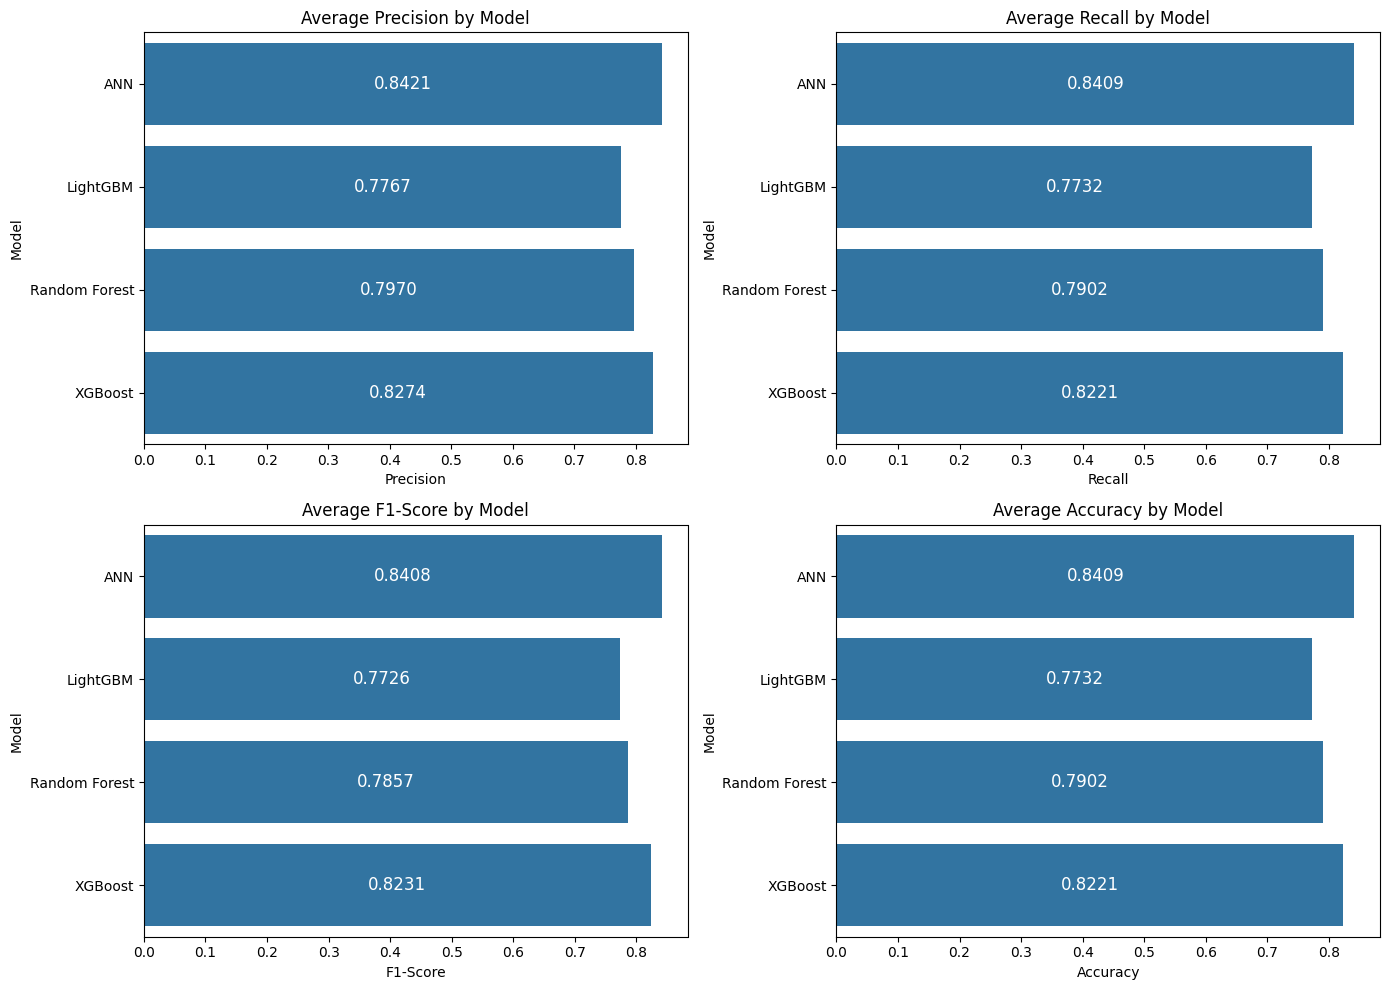

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Veriyi yükleyelim
file_path = '/content/drive/MyDrive/outputs1_resample/resampled_model_performance_results1.csv'
df = pd.read_csv(file_path)

# Model isimlerine göre gruplama ve ortalama değerler hesaplama
average_scores = df.groupby('Model')[['Precision', 'Recall', 'F1-Score', 'Accuracy']].mean().reset_index()

# Barplot için her metrik için ayrı ayrı grafik
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    sns.barplot(x=metric, y='Model', data=average_scores, ax=ax)
    ax.set_title(f'Average {metric} by Model')
    ax.set_xlabel(f'{metric}')
    ax.set_ylabel('Model')

    # Barların genişliklerini ve pozisyonlarını alıyoruz
    for j, (index, row) in enumerate(average_scores.iterrows()):
        # Barların ortasına yerleştirmek için pozisyon hesaplama
        bar = ax.patches[j]  # ax.patches artık j ile indexleniyor
        width = bar.get_width()
        x_position = bar.get_x() + width / 2

        # Beyaz renkte değerini yazıyoruz
        ax.text(x_position, bar.get_y() + bar.get_height() / 2, f"{row[metric]:.4f}",
                va='center', ha='center', fontsize=12, color='white')

plt.tight_layout()
plt.show()


            Model        Kombinasyon  Precision    Recall  F1-Score  Accuracy
11            ANN  combined_Word2Vec   0.985194  0.985466  0.985204  0.985466
8        LightGBM  combined_Word2Vec   0.952654  0.953263  0.951341  0.953263
2   Random Forest  combined_Word2Vec   0.948083  0.944429  0.933112  0.944429
5         XGBoost  combined_Word2Vec   0.985407  0.985466  0.984961  0.985466


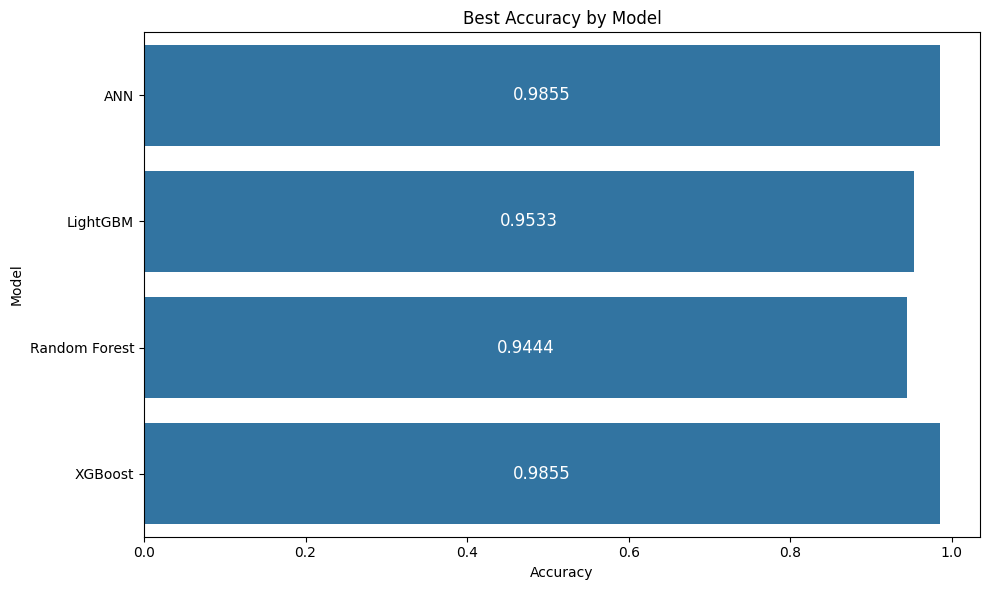

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Veriyi yükleyelim
file_path = '/content/drive/MyDrive/outputs1_resample/resampled_model_performance_results1.csv'
df = pd.read_csv(file_path)

# Her model için en yüksek accuracy'ye sahip satırı seçiyoruz
best_rows = df.loc[df.groupby('Model')['Accuracy'].idxmax()]

# Seçilen satırı gösteriyoruz
print(best_rows[['Model', 'Kombinasyon', 'Precision', 'Recall', 'F1-Score', 'Accuracy']])

# Accuracy barplot grafiğini oluşturuyoruz
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(x='Accuracy', y='Model', data=best_rows, ax=ax)
ax.set_title('Best Accuracy by Model')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Model')

# Barların genişliklerini ve pozisyonlarını alıyoruz. enumerate kullanarak bar indexlerine erişiyoruz
for i, (index, row) in enumerate(best_rows.iterrows()):
    # Barların ortasına yerleştirmek için pozisyon hesaplama
    bar = ax.patches[i]  # ax.patches artık i ile indexleniyor
    width = bar.get_width()
    x_position = bar.get_x() + width / 2

    # Beyaz renkte Accuracy değerini yazıyoruz
    ax.text(x_position, bar.get_y() + bar.get_height() / 2, f"{row['Accuracy']:.4f}",
            va='center', ha='center', fontsize=12, color='white')

plt.tight_layout()
plt.show()

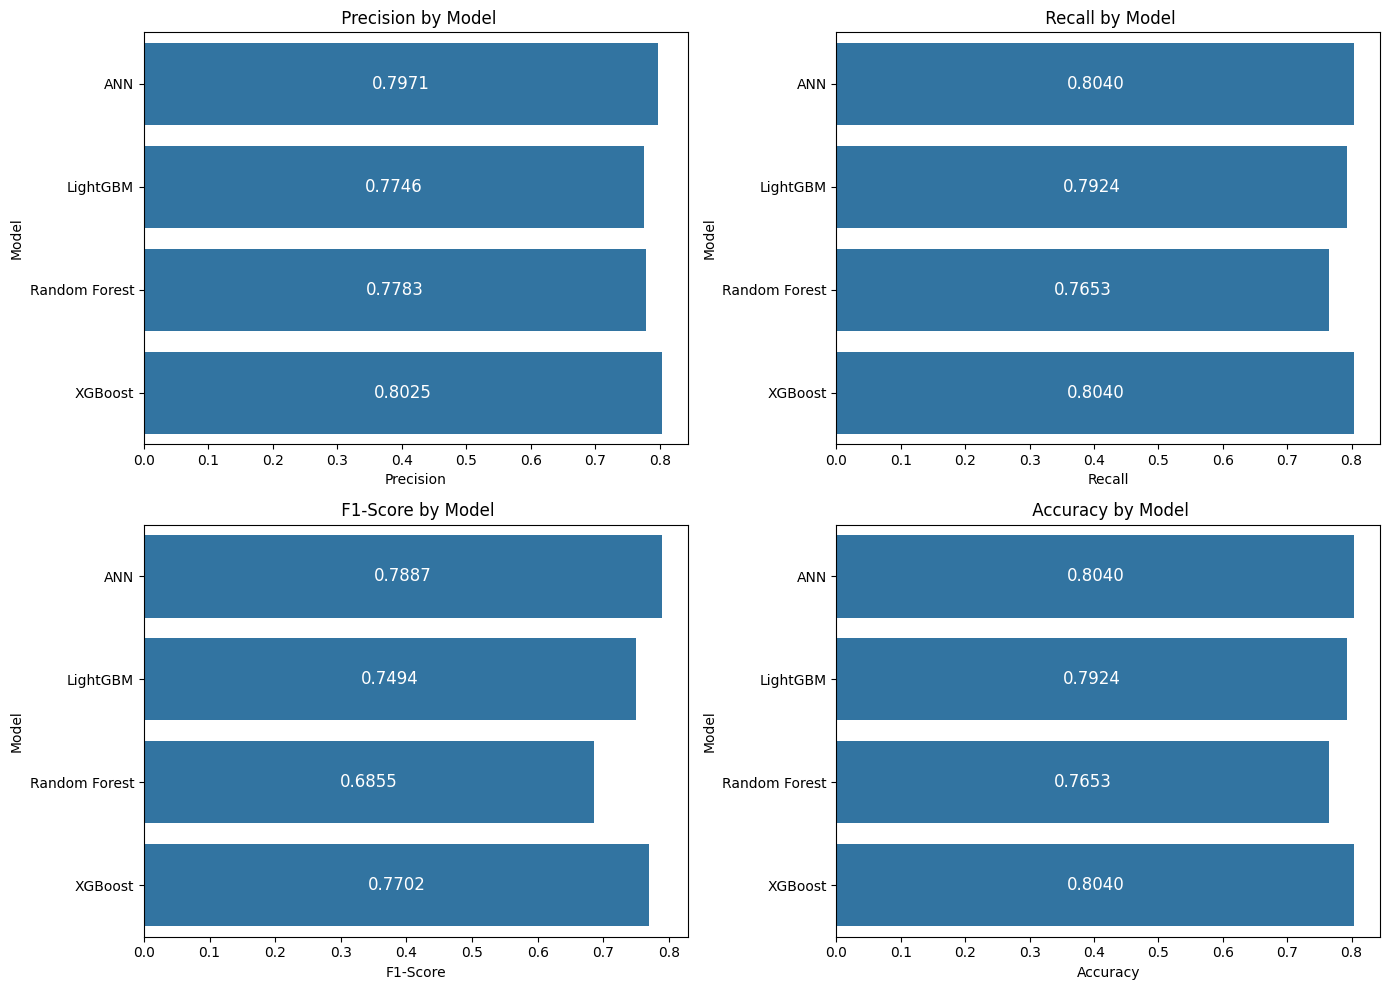

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Veriyi yükleyelim
file_path = '/content/model_performance_results.csv'
df = pd.read_csv(file_path)

# Model isimlerine göre gruplama ve ortalama değerler hesaplama
average_scores = df.groupby('Model')[['Precision', 'Recall', 'F1-Score', 'Accuracy']].mean().reset_index()

# Barplot için her metrik için ayrı ayrı grafik
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    sns.barplot(x=metric, y='Model', data=average_scores, ax=ax)
    ax.set_title(f' {metric} by Model')
    ax.set_xlabel(f'{metric}')
    ax.set_ylabel('Model')

    # Barların genişliklerini ve pozisyonlarını alıyoruz
    for j, (index, row) in enumerate(average_scores.iterrows()):
        # Barların ortasına yerleştirmek için pozisyon hesaplama
        bar = ax.patches[j]  # ax.patches artık j ile indexleniyor
        width = bar.get_width()
        x_position = bar.get_x() + width / 2

        # Beyaz renkte değerini yazıyoruz
        ax.text(x_position, bar.get_y() + bar.get_height() / 2, f"{row[metric]:.4f}",
                va='center', ha='center', fontsize=12, color='white')

plt.tight_layout()
plt.show()
